# Тематическая модель [Постнауки](http://postnauka.ru)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path = 'lectures.txt', 
                                        data_format = 'vowpal_wabbit',
                                        target_folder = 'lectures_batches',
                                        batch_size = 100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]

ARTM_model = artm.ARTM(num_topics = T, topic_names = topic_names,
                       class_ids = {"text":1, "author":1},
                       num_document_passes = 1, reuse_theta = True,
                       cache_theta = True, seed = -1)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
ARTM_model.scores.add(artm.TopTokensScore(name = 'TopTokensScore_text', num_tokens = 15,
                                          class_id = 'text'))
ARTM_model.scores.add(artm.TopTokensScore(name = 'TopTokensScore_author', num_tokens = 15,
                                          class_id = 'author'))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [8]:
ARTM_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name = 'SmoothSparsePhiRegularizer',
                                                            tau = 1e5, dictionary = dictionary,
                                                            class_ids = ['text'], 
                                                            topic_names = ['bcg']))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [9]:
ARTM_model.initialize('dictionary')
ARTM_model.fit_offline(batch_vectorizer = batch_vectorizer, num_collection_passes = 30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [10]:
ARTM_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name = 'SmoothSparsePhiRegularizer_r',
                                                            tau = -1e5, dictionary = dictionary,
                                                            class_ids = ['text'], 
                                                            topic_names = ['sbj'+str(i) for i in range(T-1)]))

Выполните еще 15 проходов по коллекции.

In [11]:
ARTM_model.fit_offline(batch_vectorizer = batch_vectorizer, num_collection_passes = 15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [12]:
# -*- coding: utf-8 -*-

class color:
    RED = '\033[91m'
    GREEN = '\033[92m'
    BLUE = '\033[94m'
    END = '\033[0m'
    
print color.RED + u'Топы слов в темах:' + color.END
    
for topic_name in ARTM_model.topic_names:
    print topic_name + ': ',
    tokens = ARTM_model.score_tracker['TopTokensScore_text'].last_tokens
    for word in tokens[topic_name]:
        print word,
    print '\n'
        
print '\n' + color.RED + u'Топы авторов в темах:' + color.END

for topic_name in ARTM_model.topic_names:
    print topic_name + ': ',
    tokens = ARTM_model.score_tracker['TopTokensScore_author'].last_tokens
    for word in tokens[topic_name]:
        print word,
    print '\n'

Топы слов в темах:
sbj0:  церковь власть русь средневековый император святой римский сага князь папа король александр византийский церковный рим 

sbj1:  планета земля атмосфера солнце солнечный белый газ карлик образовываться вокруг звезда спутник вода поверхность кислород 

sbj2:  система состояние трудность двигаться частота поведение искусственный точность относительность движение переход тест час самка самец 

sbj3:  культура понятие культурный восприятие сознание феномен личность ощущение воспринимать чувство переживание повседневный этика лосев глобальный 

sbj4:  право литература литературный искусство юрист должник собственность обязательство римский владение произведение писатель юридический собственник исполнение 

sbj5:  материал структура молекула свойство углерод применение полимер поверхность вещество кристалл металл электронный алмаз углеродный твердый 

sbj6:  фильм книга автор кино театр жанр кинематограф анекдот тема документ пьеса культовый академия герой екатерина 

sbj16:  Станислав_Дробышевский Виталий_Кушниров Александр_Шацкий Евгений_Рогожин Митчел_Резник Алиса_Вячеславова Владимир_Муронец Вера_Мильчина Раиса_Кирсанова Георгий_Базыкин Андрей_Летаров Александр_Воеводский Константин_Лукьянов Леонид_Иомдин Михаил_Эльдаров 

sbj17:  Алексей_Козырев Иван_Болдырев Владимир_Малахов Дина_Гусейнова Александр_Павлов Петр_Резвых Павел_Соколов Василий_Жарков Валентина_Харитонова Дмитрий_Балалыкин Руслан_Хестанов Александр_Воеводский Николай_Плотников Анна_Севортьян Юрий_Рогулёв 

sbj18:  Александр_Пиперски Надежда_Онипенко Петр_Аркадьев Дмитрий_Добровольский Светлана_Евграфова Борис_Иомдин Анатолий_Баранов Алексей_Шмелев Леонид_Иомдин Андрей_Кибрик Владимир_Плунгян Екатерина_Протасова Екатерина_Лютикова Вера_Подлесская Анастасия_Лопухина 

sbj19:  Дмитрий_Бовыкин Андрей_Зорин Борис_Колоницкий Раиса_Кирсанова Вера_Мильчина Мария_Майофис Алексей_Миллер Дина_Гусейнова Александр_Дмитриев Максим_Демин Мария_Неклюдова Марина_Новикова-Грунд Илья_Иткин Светлана_Б

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [219]:
sbj_topic_labels = [u"Церковь", u"Планета земля", u"Обществознание",
                    u"Культура", u"Римское право", u"Оптика",
                    u"Фильм", u"Эпоха великой французской революции",
                    u"Химическая структура вещества", u"Квантовая физика",
                    u"История России", u"Семья", u"Живая природа",
                    u"История древнего мира", u"Космос", u"Психология мышления",
                    u"Расы", u"Философия", u"Русский язык",
                    u"Великая французская буржуазная революция",
                    u"Городские технологии", u"Медицина", u"Социология",
                    u"Микроорганизмы", u"Мифы", u"Языки",
                    u"Экономический кризис", u"Биология",
                    u"Сверх проводники"]   # запишите названия тем в список
topic_labels = sbj_topic_labels + [u"Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [14]:
ARTM_model.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
phi_a = ARTM_model.get_phi(class_ids = ['author'])
theta = ARTM_model.get_theta()

print("Phi size: {}".format(phi_a.shape))
print("Theta size: {}".format(theta.shape))

Phi size: (539, 30)
Theta size: (30, 1728)


In [16]:
phi_a.head(5)

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
Александр_Четверин,0.0,0.0,0.0,0.0,0.0,4.958983e-10,0.0,0.0,0.014227,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.814207e-12,0.0,0.0
Сергей_Деев,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.014227,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
Роман_Мизюк,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.011661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
Олег_Фиговский,0.0,0.0,0.0,0.0,0.0,1.628952e-02,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0
Сергей_Шишкин,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0


In [17]:
theta.head(5)

,http://postnauka.ru/video/50406,http://postnauka.ru/video/50407,http://postnauka.ru/video/50408,http://postnauka.ru/video/50656,http://postnauka.ru/video/50659,http://postnauka.ru/video/50665,http://postnauka.ru/video/50668,http://postnauka.ru/video/50670,http://postnauka.ru/video/50699,http://postnauka.ru/video/50701,...,http://postnauka.ru/video/27934,http://postnauka.ru/video/27936,http://postnauka.ru/video/27938,http://postnauka.ru/video/27942,http://postnauka.ru/video/27944,http://postnauka.ru/video/27946,http://postnauka.ru/video/27948,http://postnauka.ru/video/27955,http://postnauka.ru/video/27957,http://postnauka.ru/video/27960
sbj0,2.710842e-07,5.000840e-03,0.000000e+00,8.347662e-05,3.697427e-03,0.000000e+00,2.501624e-01,0.000050,0.000000e+00,4.522530e-11,...,1.168778e-01,4.037218e-16,0.000000e+00,6.868038e-10,7.381896e-02,0.000000,3.186117e-15,2.507217e-02,9.813823e-07,0.000000
sbj1,2.547267e-03,1.352254e-15,5.070141e-02,4.022790e-09,1.114237e-10,1.604489e-02,2.663355e-03,0.000013,3.340088e-04,1.247495e-11,...,1.305051e-02,0.000000e+00,7.026930e-02,0.000000e+00,1.733532e-08,0.001352,1.267666e-04,1.532312e-13,8.177916e-03,0.004235
sbj2,1.305613e-03,5.754706e-06,2.494879e-02,3.358434e-12,2.570928e-09,4.650720e-03,2.338273e-16,0.007472,2.557861e-03,1.153841e-14,...,1.385647e-07,0.000000e+00,1.469348e-09,9.432017e-05,2.814730e-04,0.000000,7.838566e-10,4.722486e-05,5.928056e-11,0.009028
sbj3,4.131542e-03,1.414495e-03,1.961480e-13,2.953596e-10,1.086785e-03,1.704486e-07,4.027193e-06,0.008744,3.065149e-08,9.879735e-03,...,3.869791e-13,1.712367e-02,2.550056e-02,5.155290e-02,6.266110e-03,0.023998,5.721160e-02,0.000000e+00,4.468247e-03,0.011187
sbj4,2.109604e-11,1.003824e-02,1.551660e-06,3.910804e-04,4.664124e-03,0.000000e+00,2.678891e-03,0.029300,0.000000e+00,1.404347e-10,...,0.000000e+00,3.719238e-16,0.000000e+00,0.000000e+00,8.509502e-05,0.004864,4.792718e-03,1.287466e-10,0.000000e+00,0.000000


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

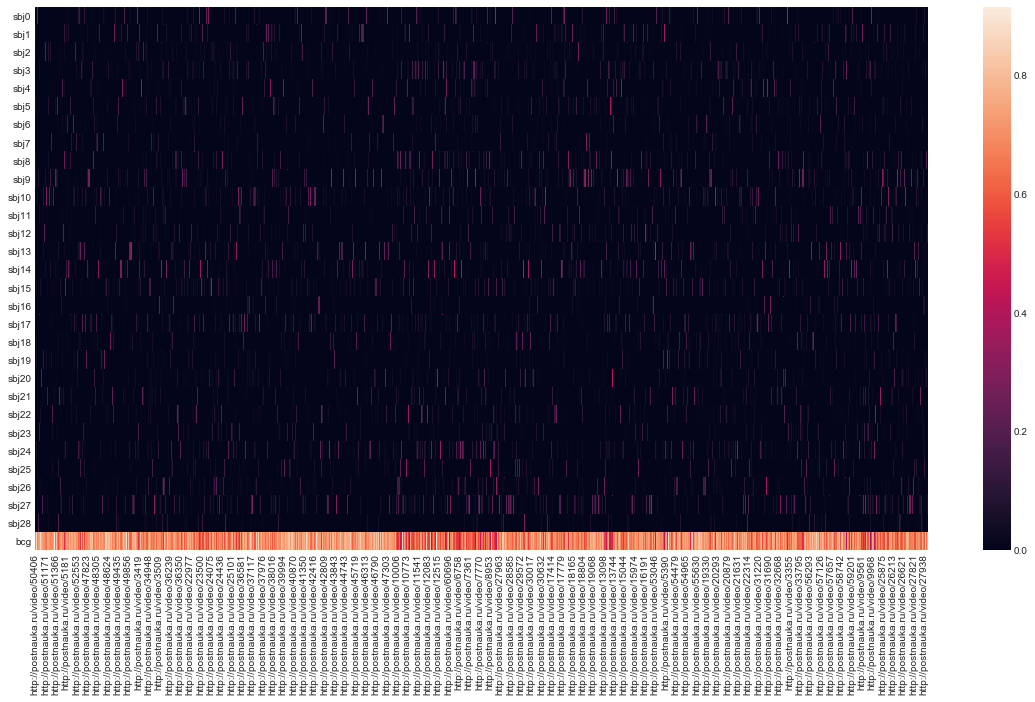

In [18]:
# Ваш код
plt.figure(figsize=(20, 10))
seaborn.heatmap(theta[:100])

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [36]:
p = pd.DataFrame(data = np.sum(theta, axis = 1) / sum(np.sum(theta, axis = 1)), 
                 columns = ['p(t)'], index = topic_names)

In [37]:
p

,p(t)
sbj0,0.011111
sbj1,0.011570
sbj2,0.008044
sbj3,0.012845
sbj4,0.008409
sbj5,0.010235
sbj6,0.006311
sbj7,0.004611
sbj8,0.013096
sbj9,0.020991


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [39]:
p.sort_values(by = 'p(t)')

,p(t)
sbj16,0.004228
sbj7,0.004611
sbj28,0.005712
sbj19,0.005977
sbj6,0.006311
sbj11,0.006416
sbj23,0.006734
sbj12,0.007678
sbj2,0.008044
sbj20,0.008090


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

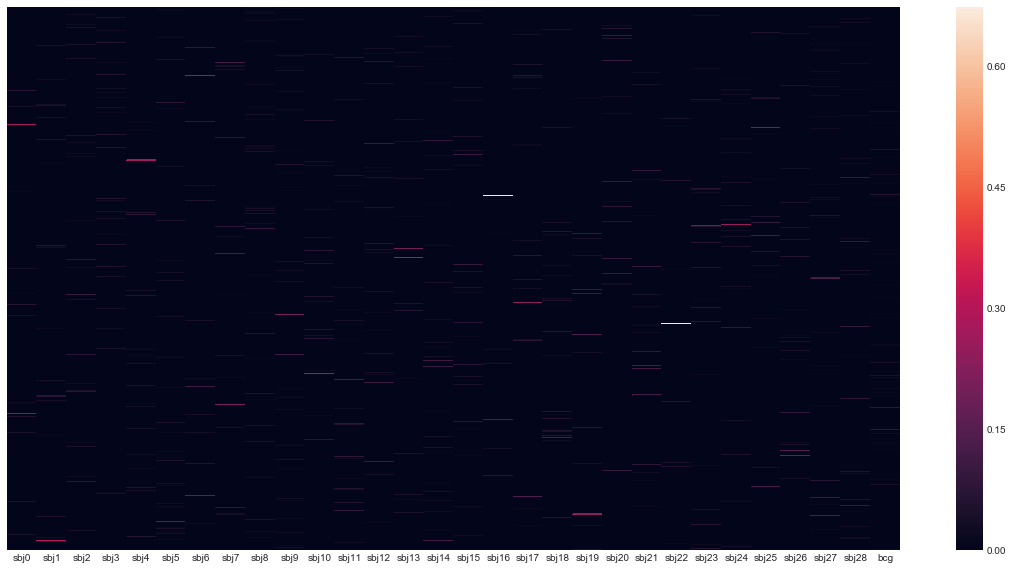

In [40]:
# Ваш код
plt.figure(figsize = (20, 10))
seaborn.heatmap(phi_a, yticklabels = False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [46]:
a = (phi_a > 0.01).sum(axis = 1)

In [49]:
a[a >= 3]

Елена_Брызгалина      3
Алина_Бодрова         3
Владимир_Белотелов    3
Ольга_Вайнштейн       3
Шринивас_Шридхар      3
Дмитрий_Лось          3
dtype: int64

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [96]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [97]:
# Ваш код
sum_t = np.sum(np.multiply(phi_a, p['p(t)'].values), axis = 1)
p_ta = np.divide(np.multiply(phi_a, p['p(t)'].values).T.values, sum_t.values)

In [105]:
p_ta.shape

(30, 539)

In [107]:
distances = pairwise_distances(p_ta.T, metric = "cosine", n_jobs = -2)
MDS_cosine = MDS(n_components = 2, n_jobs = -2, dissimilarity = "precomputed").fit_transform(distances)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

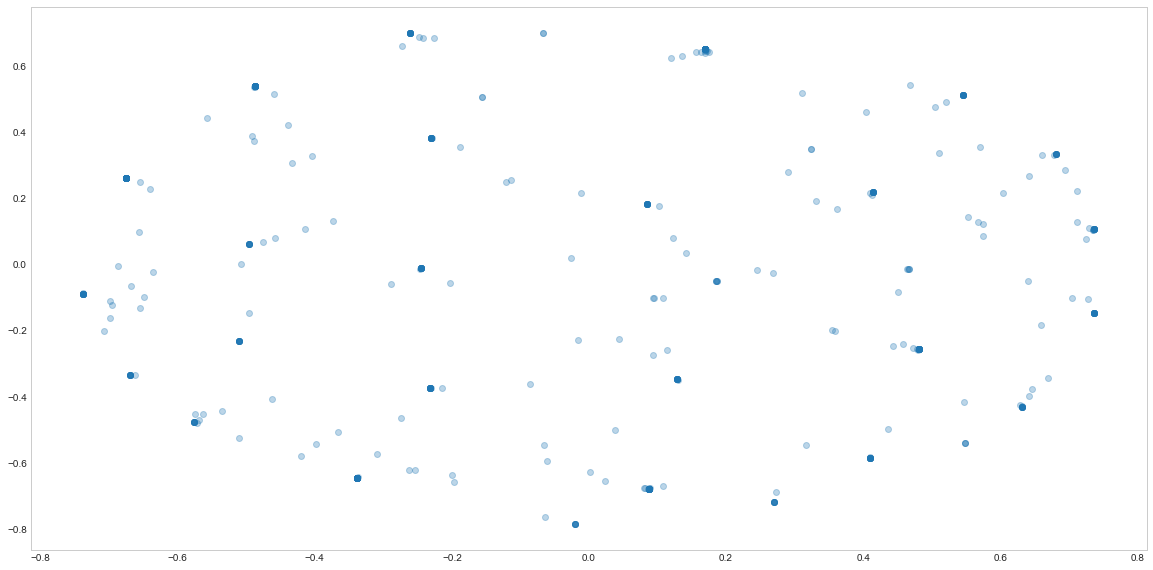

In [117]:
# Ваш код
plt.figure(figsize = (20, 10))
plt.scatter(MDS_cosine[:, 0], MDS_cosine[:, 1], alpha = 0.3)

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

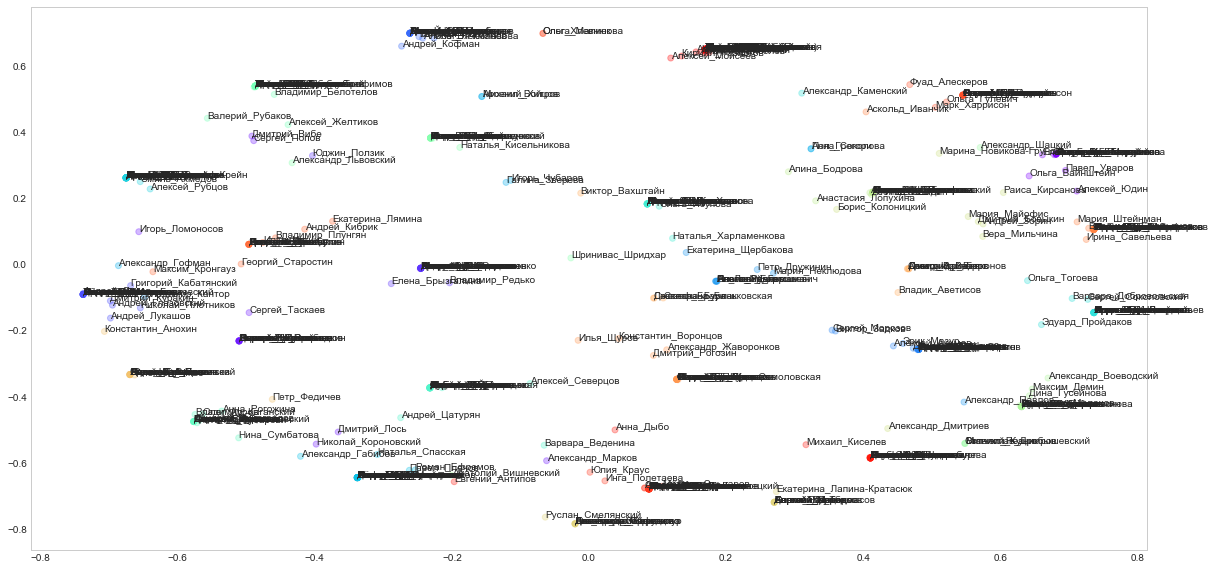

In [130]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код

from matplotlib.colors import ListedColormap

plt.figure(figsize = (20, 10))
plt.scatter(x = MDS_cosine[:, 0], y = MDS_cosine[:, 1], alpha = 0.3, 
            c = p_ta.T.argmax(axis = 1), cmap = ListedColormap(colors))

for doc, author in enumerate(MDS_cosine):
    plt.annotate(s = a.index[doc], xy = author)

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [132]:
# Ваш код
p_td = np.divide(theta.T.values, np.sum(theta, axis = 1).values)
p_td = p_td.T

In [181]:
p_td_m = p_td.argmax(axis = 1)
p_td_s = np.argsort(p_td)
print(u'Индексы наиболее вероятных документов в каждой теме:\n{}'.format(p_td_m))
print(u'Тем: {}'.format(len(p_td_s)))

Индексы наиболее вероятных документов в каждой теме:
[1457 1219 1053  729 1027 1115  479 1068 1033  798  229 1396 1182 1202
  813  342 1424  789  274 1225 1119 1637  724 1412  723  882 1417 1576
  948   39]
Тем: 30


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [140]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [141]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [222]:
# Ваш код
for i, theme in enumerate(ARTM_model.topic_names):
    if i != 29:
        display(HTML(u"<center><h1>{}</h1></center>".format(sbj_topic_labels[i])))
        tokens = ARTM_model.score_tracker['TopTokensScore_text'].last_tokens
        words = []
        for word in tokens[theme]:
            words.append(word)
        print_words = ', '.join(words)
    
        display(HTML(u"<p style=\"color: red\"> <strong>Ключевые слова темы:</strong> </p>"))
        display(HTML(u"<p style=\"color: blue\">{}</p>".format(print_words)))
        display(HTML(u"<p style=\"color: red\"> <strong>Ссылки на 10 наиболее релевантных тем:</strong> </p>"))
    
        HTML_table = u"<ol>"
        for j in range(1, 11):
            HTML_table += "<li> <a href=\"{0}\">{0}</li>".format(theta.columns[p_td_s[i][-j]])        
        HTML_table += u"</ol>"
        display(HTML(HTML_table))

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 